In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split


basis = "6-311++g**"


In [6]:
class Data(object):

    def __init__(self):
        
        self._P = [
            [], # train
            [], # val
            []  # test
        ]
        self._S = [
            [], 
            [], 
            []
        ]
        self._molecules =[
            [], 
            [], 
            []
        ]
    
    @classmethod
    def fetch_data(cls, data_path, postfix):

        S = np.load(join(data_path, "S" + postfix + ".npy"))
        P = np.load(join(data_path, "P" + postfix + ".npy"))

        molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
        
        return S, P, molecules
    
    def package_and_append(
            self, 
            S, 
            P, 
            molecules, 
            split_test, 
            split_validation
        ):
        
        ind_test = int(split_test * len(molecules))
        ind_val = int(split_validation * ind_test)
        
        self._S[0] += list(S[:ind_val])
        self._S[1] += list(S[ind_val:ind_test])
        self._S[2] += list(S[ind_test:])
        
        self._P[0] += list(P[:ind_val])
        self._P[1] += list(P[ind_val:ind_test])
        self._P[2] += list(P[ind_test:])
        
        self._molecules[0] += list(molecules[:ind_val])
        self._molecules[1] += list(molecules[ind_val:ind_test])
        self._molecules[2] += list(molecules[ind_test:])
        
    
    def include(
        self, 
        data_path, 
        postfix, 
        split_test=0.8, 
        split_validation=0.8
    ):
        
        self.package_and_append(
            *self.fetch_data(data_path, postfix), 
            split_test=split_test,
            split_validation=split_validation
        )
        
    @property
    def molecules(self):
        return self._molecules
    
    @property
    def S(self):
        return self._S
    
    @property
    def P(self):
        return self._P
    
    @property
    def p_test(self):
        return self._P[2]
    
    @property
    def p_val(self):
        return self._P[1]
    
    @property
    def p_train(self):
        return self._P[0]
    
    @property
    def s_test(self):
        return self._S[2]
    
    @property
    def s_val(self):
        return self._S[1]
    
    @property
    def s_train(self):
        return self._S[0]
    

In [7]:
data = Data()
data.include(
    data_path = "../../dataset/EthanT/",
    postfix = "EthanT"
)
data.include(
    data_path = "../../dataset/EthenT/",
    postfix = "EthenT"
)
data.include(
    data_path = "../../dataset/EthinT/",
    postfix = "EthinT"
)

# Descriptor 

In [8]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor

descriptor = AtomicNumberWeighted(
    Gaussians(*RADIAL_GAUSSIAN_MODELS["Man"]),
    SPHAngularDescriptor(15),
    BehlerCutoff1(5)
)
    
    


# Utilities 

## Calculate Descriptors and extract center blocks 

## Networks 

In [9]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            #kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(1e-6)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mae', 'mse']
    )
    
    return model



In [10]:
path = "../../models/ParticleNumberIndependent/CenterBlocks/"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-10, 
    patience=200, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.5, 
    patience=50, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=50, 
    min_lr=1e-10
)



epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4):
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    error = []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint
            ]
        )

        error.append(model.evaluate(
            dataset.testing[0], 
            dataset.testing[1], 
            verbose=1
        )[1])
    
    return error
    

# C  

## Compute inputs 

In [12]:

name_C = "model_C.h5"


In [13]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset

dataset_C = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.P,
    "C"
)

In [15]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


species = "C"

dim_C = N_BASIS[basis][species]
dim_C_triu = dim_C * (dim_C + 1) // 2


In [16]:
descriptor.number_of_descriptors, dim_C_triu

(562, 253)

In [21]:
structure_C = [700, 500, 300]

In [22]:
keras.backend.clear_session()

In [23]:
model_C = make_model(
    structure=structure_C,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_C_triu
)

model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 700)               394100    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               350500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_3 (Dense)              (None, 253)               76153     
Total params: 971,053
Trainable params: 971,053
Non-trainable params: 0
_________________________________________________________________


In [ ]:

train_model(
    model_C, 
    dataset_C, 
    path + name_C,
    learning_rate=1e-4
)

Train on 3840 samples, validate on 960 samples
Epoch 1/1000
3840/3840 [==============================] - 3s 711us/step - loss: 0.0126 - mean_absolute_error: 0.0740 - mean_squared_error: 0.0117 - val_loss: 0.0099 - val_mean_absolute_error: 0.0615 - val_mean_squared_error: 0.0089

Epoch 00001: val_mean_squared_error improved from inf to 0.00894, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_C.h5
Epoch 2/1000
3840/3840 [==============================] - 1s 368us/step - loss: 0.0028 - mean_absolute_error: 0.0313 - mean_squared_error: 0.0018 - val_loss: 0.0062 - val_mean_absolute_error: 0.0442 - val_mean_squared_error: 0.0052

Epoch 00002: val_mean_squared_error improved from 0.00894 to 0.00522, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_C.h5
Epoch 3/1000
3840/3840 [==============================] - 1s 357us/step - loss: 0.0020 - mean_absolute_error: 0.0232 - mean_squared_error: 0.0011 - val_loss: 0.0046 - val_mean_absolute_error: 0

Epoch 23/1000
3840/3840 [==============================] - 2s 424us/step - loss: 0.0011 - mean_absolute_error: 0.0096 - mean_squared_error: 2.3779e-04 - val_loss: 0.0017 - val_mean_absolute_error: 0.0173 - val_mean_squared_error: 9.0580e-04

Epoch 00023: val_mean_squared_error did not improve from 0.00090
Epoch 24/1000
3840/3840 [==============================] - 2s 449us/step - loss: 0.0011 - mean_absolute_error: 0.0096 - mean_squared_error: 2.4285e-04 - val_loss: 0.0017 - val_mean_absolute_error: 0.0172 - val_mean_squared_error: 8.9769e-04

Epoch 00024: val_mean_squared_error improved from 0.00090 to 0.00090, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_C.h5
Epoch 25/1000
3840/3840 [==============================] - 1s 383us/step - loss: 0.0010 - mean_absolute_error: 0.0094 - mean_squared_error: 2.3864e-04 - val_loss: 0.0017 - val_mean_absolute_error: 0.0172 - val_mean_squared_error: 8.9786e-04

Epoch 00025: val_mean_squared_error did not improve from 0.0

3840/3840 [==============================] - 3s 830us/step - loss: 7.4529e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.4830e-04 - val_loss: 0.0014 - val_mean_absolute_error: 0.0150 - val_mean_squared_error: 8.0216e-04

Epoch 00047: val_mean_squared_error did not improve from 0.00079
Epoch 48/1000
3840/3840 [==============================] - 3s 833us/step - loss: 7.3183e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.4522e-04 - val_loss: 0.0014 - val_mean_absolute_error: 0.0149 - val_mean_squared_error: 7.8616e-04

Epoch 00048: val_mean_squared_error did not improve from 0.00079
Epoch 49/1000
3840/3840 [==============================] - 3s 681us/step - loss: 7.1440e-04 - mean_absolute_error: 0.0070 - mean_squared_error: 1.3818e-04 - val_loss: 0.0014 - val_mean_absolute_error: 0.0149 - val_mean_squared_error: 7.8826e-04

Epoch 00049: val_mean_squared_error did not improve from 0.00079
Epoch 50/1000
3840/3840 [==============================] - 3s 711us/step - loss: 


Epoch 00071: val_mean_squared_error did not improve from 0.00070
Epoch 72/1000
3840/3840 [==============================] - 1s 348us/step - loss: 4.4092e-04 - mean_absolute_error: 0.0055 - mean_squared_error: 9.0870e-05 - val_loss: 0.0011 - val_mean_absolute_error: 0.0132 - val_mean_squared_error: 7.0585e-04

Epoch 00072: val_mean_squared_error did not improve from 0.00070
Epoch 73/1000
3840/3840 [==============================] - 2s 417us/step - loss: 4.3334e-04 - mean_absolute_error: 0.0056 - mean_squared_error: 9.1960e-05 - val_loss: 0.0010 - val_mean_absolute_error: 0.0131 - val_mean_squared_error: 6.9302e-04

Epoch 00073: val_mean_squared_error improved from 0.00070 to 0.00069, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_C.h5
Epoch 74/1000
3840/3840 [==============================] - 2s 436us/step - loss: 4.2567e-04 - mean_absolute_error: 0.0055 - mean_squared_error: 9.2839e-05 - val_loss: 0.0010 - val_mean_absolute_error: 0.0131 - val_mean_squared_e

3840/3840 [==============================] - 2s 400us/step - loss: 2.4866e-04 - mean_absolute_error: 0.0046 - mean_squared_error: 6.4425e-05 - val_loss: 8.4202e-04 - val_mean_absolute_error: 0.0123 - val_mean_squared_error: 6.6040e-04

Epoch 00096: val_mean_squared_error did not improve from 0.00065
Epoch 97/1000
3840/3840 [==============================] - 2s 421us/step - loss: 2.4287e-04 - mean_absolute_error: 0.0045 - mean_squared_error: 6.3779e-05 - val_loss: 8.3639e-04 - val_mean_absolute_error: 0.0122 - val_mean_squared_error: 6.5984e-04

Epoch 00097: val_mean_squared_error did not improve from 0.00065
Epoch 98/1000
3840/3840 [==============================] - 2s 398us/step - loss: 2.3767e-04 - mean_absolute_error: 0.0045 - mean_squared_error: 6.3583e-05 - val_loss: 8.4134e-04 - val_mean_absolute_error: 0.0122 - val_mean_squared_error: 6.6973e-04

Epoch 00098: val_mean_squared_error did not improve from 0.00065
Epoch 99/1000
3840/3840 [==============================] - 2s 432us/s


Epoch 00120: val_mean_squared_error did not improve from 0.00063
Epoch 121/1000
3840/3840 [==============================] - 2s 405us/step - loss: 1.3197e-04 - mean_absolute_error: 0.0037 - mean_squared_error: 4.2711e-05 - val_loss: 7.3956e-04 - val_mean_absolute_error: 0.0116 - val_mean_squared_error: 6.5160e-04

Epoch 00121: val_mean_squared_error did not improve from 0.00063
Epoch 122/1000
3840/3840 [==============================] - 2s 410us/step - loss: 1.2912e-04 - mean_absolute_error: 0.0037 - mean_squared_error: 4.2424e-05 - val_loss: 7.2499e-04 - val_mean_absolute_error: 0.0114 - val_mean_squared_error: 6.3960e-04

Epoch 00122: val_mean_squared_error did not improve from 0.00063
Epoch 123/1000
3840/3840 [==============================] - 2s 396us/step - loss: 1.2719e-04 - mean_absolute_error: 0.0037 - mean_squared_error: 4.3031e-05 - val_loss: 7.2849e-04 - val_mean_absolute_error: 0.0114 - val_mean_squared_error: 6.4556e-04

Epoch 00123: val_mean_squared_error did not improve

3840/3840 [==============================] - 2s 521us/step - loss: 7.3679e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 2.9685e-05 - val_loss: 6.8300e-04 - val_mean_absolute_error: 0.0111 - val_mean_squared_error: 6.3959e-04

Epoch 00146: val_mean_squared_error did not improve from 0.00062
Epoch 147/1000
3840/3840 [==============================] - 2s 456us/step - loss: 7.3510e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 3.0649e-05 - val_loss: 6.7527e-04 - val_mean_absolute_error: 0.0111 - val_mean_squared_error: 6.3298e-04

Epoch 00147: val_mean_squared_error did not improve from 0.00062
Epoch 148/1000
3840/3840 [==============================] - 2s 484us/step - loss: 7.2716e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 3.0957e-05 - val_loss: 6.7820e-04 - val_mean_absolute_error: 0.0110 - val_mean_squared_error: 6.3699e-04

Epoch 00148: val_mean_squared_error did not improve from 0.00062
Epoch 149/1000
3840/3840 [==============================] - 2s 505u

3840/3840 [==============================] - 2s 409us/step - loss: 4.9251e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 2.4243e-05 - val_loss: 6.6317e-04 - val_mean_absolute_error: 0.0108 - val_mean_squared_error: 6.3839e-04

Epoch 00171: val_mean_squared_error did not improve from 0.00062
Epoch 172/1000
3840/3840 [==============================] - 2s 391us/step - loss: 4.7649e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 2.3074e-05 - val_loss: 6.5353e-04 - val_mean_absolute_error: 0.0107 - val_mean_squared_error: 6.2917e-04

Epoch 00172: val_mean_squared_error did not improve from 0.00062
Epoch 173/1000
3840/3840 [==============================] - 1s 347us/step - loss: 4.6455e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 2.2316e-05 - val_loss: 6.4386e-04 - val_mean_absolute_error: 0.0107 - val_mean_squared_error: 6.1993e-04

Epoch 00173: val_mean_squared_error did not improve from 0.00062
Epoch 174/1000
3840/3840 [==============================] - 1s 353u

3840/3840 [==============================] - 2s 634us/step - loss: 3.5890e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.8658e-05 - val_loss: 6.3666e-04 - val_mean_absolute_error: 0.0106 - val_mean_squared_error: 6.1951e-04

Epoch 00196: val_mean_squared_error did not improve from 0.00061
Epoch 197/1000
3840/3840 [==============================] - 2s 632us/step - loss: 3.5762e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.8709e-05 - val_loss: 6.3236e-04 - val_mean_absolute_error: 0.0106 - val_mean_squared_error: 6.1540e-04

Epoch 00197: val_mean_squared_error did not improve from 0.00061
Epoch 198/1000
3840/3840 [==============================] - 2s 475us/step - loss: 3.5357e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.8490e-05 - val_loss: 6.4260e-04 - val_mean_absolute_error: 0.0106 - val_mean_squared_error: 6.2583e-04

Epoch 00198: val_mean_squared_error did not improve from 0.00061
Epoch 199/1000
3840/3840 [==============================] - 2s 473u


Epoch 00221: val_mean_squared_error did not improve from 0.00061
Epoch 222/1000
3840/3840 [==============================] - 3s 871us/step - loss: 2.9067e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.5701e-05 - val_loss: 6.3662e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 6.2330e-04

Epoch 00222: val_mean_squared_error did not improve from 0.00061
Epoch 223/1000
3840/3840 [==============================] - 3s 909us/step - loss: 2.8182e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.4922e-05 - val_loss: 6.3391e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 6.2069e-04

Epoch 00223: val_mean_squared_error did not improve from 0.00061
Epoch 224/1000
3840/3840 [==============================] - 3s 702us/step - loss: 2.9002e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.5846e-05 - val_loss: 6.2837e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 6.1528e-04

Epoch 00224: val_mean_squared_error did not improve

3840/3840 [==============================] - 2s 457us/step - loss: 2.4553e-05 - mean_absolute_error: 0.0021 - mean_squared_error: 1.3338e-05 - val_loss: 6.3356e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 6.2236e-04

Epoch 00247: val_mean_squared_error did not improve from 0.00061
Epoch 248/1000
3840/3840 [==============================] - 2s 427us/step - loss: 2.4787e-05 - mean_absolute_error: 0.0022 - mean_squared_error: 1.3625e-05 - val_loss: 6.1971e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 6.0860e-04

Epoch 00248: val_mean_squared_error improved from 0.00061 to 0.00061, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_C.h5
Epoch 249/1000
3840/3840 [==============================] - 2s 401us/step - loss: 2.3623e-05 - mean_absolute_error: 0.0021 - mean_squared_error: 1.2545e-05 - val_loss: 6.3360e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 6.2255e-04

Epoch 00249: val_mean_squared_error did not impr


Epoch 00272: val_mean_squared_error did not improve from 0.00061
Epoch 273/1000
3840/3840 [==============================] - 1s 342us/step - loss: 2.1408e-05 - mean_absolute_error: 0.0020 - mean_squared_error: 1.1682e-05 - val_loss: 6.3578e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 6.2609e-04

Epoch 00273: val_mean_squared_error did not improve from 0.00061
Epoch 274/1000
3840/3840 [==============================] - 2s 445us/step - loss: 2.1455e-05 - mean_absolute_error: 0.0020 - mean_squared_error: 1.1785e-05 - val_loss: 6.2955e-04 - val_mean_absolute_error: 0.0104 - val_mean_squared_error: 6.1991e-04

Epoch 00274: val_mean_squared_error did not improve from 0.00061
Epoch 275/1000
3840/3840 [==============================] - 2s 531us/step - loss: 2.1611e-05 - mean_absolute_error: 0.0020 - mean_squared_error: 1.1995e-05 - val_loss: 6.2348e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 6.1388e-04

Epoch 00275: val_mean_squared_error did not improve

#  H

In [71]:
name_H = "model_H_" + postfix + ".h5"

In [72]:
dataset_H = make_center_block_dataset(
    descriptor,
    molecules,
    (p_train, p_val, p_test),
    "H"
)

In [73]:
species = "H"
dim_H = N_BASIS[basis][species]
dim_H_triu = dim_H * (dim_H + 1) // 2

descriptor.number_of_descriptors, dim_H_triu

(562, 28)

In [74]:
structure_H = [250, 100, 50]

In [75]:
model_H = make_model(
    structure=structure_H,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_H_triu
)

model_H.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 250)               140750    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               25100     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 28)                1428      
Total params: 172,328
Trainable params: 172,328
Non-trainable params: 0
_________________________________________________________________


In [ ]:


train_model(
    model_H, 
    dataset_H,
    path + name_H,
    learning_rate=1e-3
)

Train on 2560 samples, validate on 640 samples
Epoch 1/1000
2560/2560 [==============================] - 1s 215us/step - loss: 0.0253 - mean_absolute_error: 0.0999 - mean_squared_error: 0.0251 - val_loss: 0.0028 - val_mean_absolute_error: 0.0400 - val_mean_squared_error: 0.0026

Epoch 00001: val_mean_squared_error improved from inf to 0.00264, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 2/1000
2560/2560 [==============================] - 0s 99us/step - loss: 0.0024 - mean_absolute_error: 0.0292 - mean_squared_error: 0.0023 - val_loss: 0.0015 - val_mean_absolute_error: 0.0266 - val_mean_squared_error: 0.0013

Epoch 00002: val_mean_squared_error improved from 0.00264 to 0.00131, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 3/1000
2560/2560 [==============================] - 0s 99us/step - loss: 0.0020 - mean_absolute_error: 0.0233 - mean_squared_error: 0.0018 - val_loss: 8.5750e-04 - val_mean_a

Epoch 23/1000
2560/2560 [==============================] - 0s 102us/step - loss: 2.2550e-04 - mean_absolute_error: 0.0057 - mean_squared_error: 6.0400e-05 - val_loss: 2.3785e-04 - val_mean_absolute_error: 0.0065 - val_mean_squared_error: 7.3140e-05

Epoch 00023: val_mean_squared_error improved from 0.00007 to 0.00007, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 24/1000
2560/2560 [==============================] - 0s 97us/step - loss: 2.2857e-04 - mean_absolute_error: 0.0057 - mean_squared_error: 6.4249e-05 - val_loss: 2.4134e-04 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 7.7439e-05

Epoch 00024: val_mean_squared_error did not improve from 0.00007
Epoch 25/1000
2560/2560 [==============================] - 0s 101us/step - loss: 2.2656e-04 - mean_absolute_error: 0.0056 - mean_squared_error: 6.3075e-05 - val_loss: 2.3947e-04 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.6401e-05

Epoch 00025: val_mean_squared_


Epoch 00069: val_mean_squared_error did not improve from 0.00002
Epoch 70/1000
2560/2560 [==============================] - 0s 166us/step - loss: 1.1353e-04 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2529e-05 - val_loss: 1.1841e-04 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.8356e-05

Epoch 00070: val_mean_squared_error improved from 0.00002 to 0.00002, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 71/1000
2560/2560 [==============================] - 0s 133us/step - loss: 1.1189e-04 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2779e-05 - val_loss: 1.1767e-04 - val_mean_absolute_error: 0.0031 - val_mean_squared_error: 1.9516e-05

Epoch 00071: val_mean_squared_error did not improve from 0.00002
Epoch 72/1000
2560/2560 [==============================] - 0s 121us/step - loss: 1.1024e-04 - mean_absolute_error: 0.0026 - mean_squared_error: 1.3029e-05 - val_loss: 1.1413e-04 - val_mean_absolute_error: 0.0030 -


Epoch 00094: val_mean_squared_error improved from 0.00002 to 0.00002, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 95/1000
2560/2560 [==============================] - 0s 82us/step - loss: 6.6232e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.2725e-05 - val_loss: 7.1696e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.9041e-05

Epoch 00095: val_mean_squared_error did not improve from 0.00002
Epoch 96/1000
2560/2560 [==============================] - 0s 83us/step - loss: 6.5189e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.3367e-05 - val_loss: 6.8167e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.7193e-05

Epoch 00096: val_mean_squared_error did not improve from 0.00002
Epoch 97/1000
2560/2560 [==============================] - 0s 88us/step - loss: 6.2423e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.2273e-05 - val_loss: 6.6937e-05 - val_mean_absolute_error: 0.0028 - va


Epoch 00119: val_mean_squared_error did not improve from 0.00001
Epoch 120/1000
2560/2560 [==============================] - 0s 135us/step - loss: 3.0982e-05 - mean_absolute_error: 0.0022 - mean_squared_error: 1.0229e-05 - val_loss: 3.5941e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.5645e-05

Epoch 00120: val_mean_squared_error did not improve from 0.00001
Epoch 121/1000
2560/2560 [==============================] - 0s 126us/step - loss: 3.0163e-05 - mean_absolute_error: 0.0022 - mean_squared_error: 1.0305e-05 - val_loss: 3.4791e-05 - val_mean_absolute_error: 0.0025 - val_mean_squared_error: 1.5382e-05

Epoch 00121: val_mean_squared_error did not improve from 0.00001
Epoch 122/1000
2560/2560 [==============================] - 0s 117us/step - loss: 2.9354e-05 - mean_absolute_error: 0.0022 - mean_squared_error: 1.0361e-05 - val_loss: 3.1291e-05 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 1.2705e-05

Epoch 00122: val_mean_squared_error improved from 0


Epoch 00143: val_mean_squared_error did not improve from 0.00001
Epoch 144/1000
2560/2560 [==============================] - 1s 197us/step - loss: 1.3040e-05 - mean_absolute_error: 0.0017 - mean_squared_error: 6.3901e-06 - val_loss: 1.6470e-05 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 9.9796e-06

Epoch 00144: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 145/1000
2560/2560 [==============================] - 0s 145us/step - loss: 1.2746e-05 - mean_absolute_error: 0.0017 - mean_squared_error: 6.4260e-06 - val_loss: 1.5688e-05 - val_mean_absolute_error: 0.0019 - val_mean_squared_error: 9.5204e-06

Epoch 00145: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 146/1000
2560/2560 [==============================] - 0s 165us/step - loss: 1.2579e-05 - mean_absolute_error: 0.00


Epoch 00190: val_mean_squared_error improved from 0.00001 to 0.00001, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 191/1000
2560/2560 [==============================] - 0s 158us/step - loss: 4.7357e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.4637e-06 - val_loss: 8.0238e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 6.7635e-06

Epoch 00191: val_mean_squared_error did not improve from 0.00001
Epoch 192/1000
2560/2560 [==============================] - 0s 145us/step - loss: 4.5172e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.2629e-06 - val_loss: 8.0707e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 6.8297e-06

Epoch 00192: val_mean_squared_error did not improve from 0.00001
Epoch 193/1000
2560/2560 [==============================] - 0s 140us/step - loss: 4.6680e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.4296e-06 - val_loss: 8.5062e-06 - val_mean_absolute_error: 0.001

2560/2560 [==============================] - 0s 143us/step - loss: 4.8019e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.6755e-06 - val_loss: 7.8986e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 6.7811e-06

Epoch 00216: val_mean_squared_error did not improve from 0.00001
Epoch 217/1000
2560/2560 [==============================] - 0s 137us/step - loss: 4.5572e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.4469e-06 - val_loss: 7.1687e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 6.0869e-06

Epoch 00217: val_mean_squared_error did not improve from 0.00001
Epoch 218/1000
2560/2560 [==============================] - 0s 118us/step - loss: 4.0754e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 3.0083e-06 - val_loss: 7.6589e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 6.5723e-06

Epoch 00218: val_mean_squared_error did not improve from 0.00001
Epoch 219/1000
2560/2560 [==============================] - 0s 115u

2560/2560 [==============================] - 1s 322us/step - loss: 2.6721e-06 - mean_absolute_error: 9.4403e-04 - mean_squared_error: 1.8649e-06 - val_loss: 5.9100e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 5.0976e-06

Epoch 00265: val_mean_squared_error did not improve from 0.00000
Epoch 266/1000
2560/2560 [==============================] - 1s 360us/step - loss: 2.8210e-06 - mean_absolute_error: 9.7877e-04 - mean_squared_error: 2.0040e-06 - val_loss: 5.9462e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 5.1196e-06

Epoch 00266: val_mean_squared_error did not improve from 0.00000
Epoch 267/1000
2560/2560 [==============================] - 1s 330us/step - loss: 2.9093e-06 - mean_absolute_error: 9.9338e-04 - mean_squared_error: 2.0879e-06 - val_loss: 6.0325e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 5.2171e-06

Epoch 00267: val_mean_squared_error did not improve from 0.00000
Epoch 268/1000
2560/2560 [=============================

2560/2560 [==============================] - 0s 186us/step - loss: 1.7530e-06 - mean_absolute_error: 6.7402e-04 - mean_squared_error: 9.6857e-07 - val_loss: 4.3998e-06 - val_mean_absolute_error: 9.8598e-04 - val_mean_squared_error: 3.6325e-06

Epoch 00290: val_mean_squared_error improved from 0.00000 to 0.00000, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 291/1000
2560/2560 [==============================] - 0s 189us/step - loss: 1.3996e-06 - mean_absolute_error: 5.6815e-04 - mean_squared_error: 6.4817e-07 - val_loss: 4.3531e-06 - val_mean_absolute_error: 9.7317e-04 - val_mean_squared_error: 3.6143e-06

Epoch 00291: val_mean_squared_error improved from 0.00000 to 0.00000, saving model to ../../models/ParticleNumberIndependent/CenterBlocks/model_H_EthenT.h5
Epoch 292/1000
2560/2560 [==============================] - 0s 194us/step - loss: 1.3182e-06 - mean_absolute_error: 5.4657e-04 - mean_squared_error: 5.8701e-07 - val_loss: 4.2924e-06 - 


Epoch 00313: val_mean_squared_error did not improve from 0.00000
Epoch 314/1000
2560/2560 [==============================] - 1s 201us/step - loss: 1.3197e-06 - mean_absolute_error: 5.9704e-04 - mean_squared_error: 7.2325e-07 - val_loss: 4.1805e-06 - val_mean_absolute_error: 9.7632e-04 - val_mean_squared_error: 3.5834e-06

Epoch 00314: val_mean_squared_error did not improve from 0.00000
Epoch 315/1000
2560/2560 [==============================] - 0s 150us/step - loss: 1.3549e-06 - mean_absolute_error: 6.0339e-04 - mean_squared_error: 7.5909e-07 - val_loss: 4.2077e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 3.6127e-06

Epoch 00315: val_mean_squared_error did not improve from 0.00000
Epoch 316/1000
2560/2560 [==============================] - 0s 156us/step - loss: 1.3227e-06 - mean_absolute_error: 5.9557e-04 - mean_squared_error: 7.2813e-07 - val_loss: 4.1790e-06 - val_mean_absolute_error: 9.8558e-04 - val_mean_squared_error: 3.5862e-06

Epoch 00316: val_mean_squared_e

# Test the Guess

In [10]:
model_C = keras.models.load_model(path + name_C)
model_H = keras.models.load_model(path + name_H)

networks = {
    "C": model_C,
    "H": model_H
}

In [23]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from pyscf.scf.hf import init_guess_by_wolfsberg_helmholtz


def init_guess_by_ann(mol, descriptor):
    
    p  = init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()).copy() # TODO set up my own GWH in SCFInitialGuess
    
    for atom_index, atom in enumerate(mol.species):
        
        mask = mol.make_atom_mask(atom_index)
        
        
        G = descriptor.calculate_atom_descriptor(
            atom_index, 
            mol,
            descriptor.number_of_descriptors
        )
        
        #f(G)
        f = networks[atom].predict(G.reshape(1, -1))
        
        f_batch = reconstruct_from_triu(
            f,
            N_BASIS[mol.basis][atom]
        )
        
        p[mask] = f_batch.flatten()
        
    return p
        
    

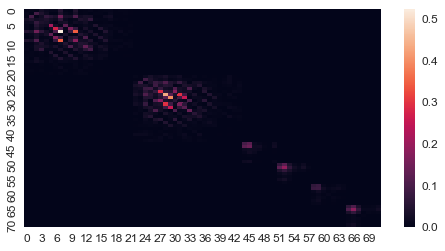

In [27]:
p_nn = np.array([
    init_guess_by_ann(mol, descriptor) for mol in molecules[2]
])

## Analysis 

In [28]:
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    #train=(s_train, p_train),
    train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=0,
    std=1
)

In [30]:
from SCFInitialGuess.utilities.analysis import \
    make_results_str, measure_all_quantities, mf_initializer


print(make_results_str(measure_all_quantities(
    p_nn,
    dataset,
    molecules[2],
    n_electrons,
    mf_initializer,
    dim=dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2018-11-12 22:47:00: Iteration calculation: 0
[ ] 2018-11-12 22:47:01: Iteration calculation: 1
[ ] 2018-11-12 22:47:02: Iteration calculation: 2
[ ] 2018-11-12 22:47:02: Iteration calculation: 3
[ ] 2018-11-12 22:47:03: Iteration calculation: 4
[ ] 2018-11-12 22:47:04: Iteration calculation: 5
[ ] 2018-11-12 22:47:05: Iteration calculation: 6
[ ] 2018-11-12 22:47:05: Iteration calculation: 7
[ ] 2018-11-12 22:47:06: Iteration calculation: 8
[ ] 2018-11-12 22:47:06: Iteration calculation: 9
[ ] 2018-11-12 22:47:07: Iteration calculation: 10
[ ] 2018-11-12 22:47:07: Iteration calculation: 11
[ ] 2018-11-12 22:47:08: Iteration calculation: 12
[ ] 2018-11-12 22:47:08: Iteration calculation: 13
[ ] 2018-11-12 22:47:09: Iteration calculation: 14
[ ] 2018-11-12 22:47:10: Iteration calculation: 15
[ ] 2018-11-12 22:47:10: Iteration calculation: 16
[ ] 2018-11-12 22:47:11: Iteration calculation: 17
[ ] 2018-11-12 22:47:11: Iteration calculation: 18
[ ] 2018-11-12 22:47:12: Iteration calcul

[ ] 2018-11-12 22:48:43: Iteration calculation: 160
[ ] 2018-11-12 22:48:44: Iteration calculation: 161
[ ] 2018-11-12 22:48:44: Iteration calculation: 162
[ ] 2018-11-12 22:48:45: Iteration calculation: 163
[ ] 2018-11-12 22:48:46: Iteration calculation: 164
[ ] 2018-11-12 22:48:47: Iteration calculation: 165
[ ] 2018-11-12 22:48:47: Iteration calculation: 166
[ ] 2018-11-12 22:48:48: Iteration calculation: 167
[ ] 2018-11-12 22:48:49: Iteration calculation: 168
[ ] 2018-11-12 22:48:49: Iteration calculation: 169
[ ] 2018-11-12 22:48:50: Iteration calculation: 170
[ ] 2018-11-12 22:48:50: Iteration calculation: 171
[ ] 2018-11-12 22:48:51: Iteration calculation: 172
[ ] 2018-11-12 22:48:52: Iteration calculation: 173
[ ] 2018-11-12 22:48:53: Iteration calculation: 174
[ ] 2018-11-12 22:48:53: Iteration calculation: 175
[ ] 2018-11-12 22:48:54: Iteration calculation: 176
[ ] 2018-11-12 22:48:55: Iteration calculation: 177
[ ] 2018-11-12 22:48:55: Iteration calculation: 178
[ ] 2018-11-